# Sample Julia Notebook - Downloading and using data from Amazon S3
[![Open In Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/aws/studio-lab-examples/blob/main/use-julia-in-studio-lab/2-sample-julia-nb.ipynb)

## Installing packages

As we did in the Installing Julia notebook, we use the `Pkg.add` command to install additional packages for this notebook.

 - [Gadfly](http://gadflyjl.org/stable/): grammar of graphics plotting, similar to ggplot in R
 - [AWS](https://github.com/JuliaCloud/AWS.jl): third-party SDK for connecting to AWS resources
 - [AWSS3](https://github.com/JuliaCloud/AWSS3.jl): high-level third-party interface to [Amazon Simple Storage Service (Amazon S3)](https://aws.amazon.com/s3/)
 - [DataFrames](https://dataframes.juliadata.org/stable/): data structure for working with tabular data, similar to [Pandas](https://pandas.pydata.org/) for Python
 - [Query](http://www.queryverse.org/Query.jl/stable/): convenience functions for working with DataFrames and other queryable data sources, similar to [dplyr](https://www.rdocumentation.org/packages/dplyr/versions/0.7.8) in R.
 - [JSON](https://github.com/JuliaIO/JSON.jl): library for parsing JSON data
 - [TranscodingStreams](https://juliaio.github.io/TranscodingStreams.jl/latest/): framework for working with encoded data
 - [CodecZlib](https://github.com/JuliaIO/CodecZlib.jl): zlib compression codec for use with TranscodingStreams; allows us to work with gzipped data.
 
After installing the packages, you'll load them in this notebook.

In [1]:
using Pkg
Pkg.add(["Gadfly", "AWS", "AWSS3", "DataFrames", "Query", "JSON", "TranscodingStreams", "CodecZlib"])

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Crayons ───────────────────── v4.0.4
   Installed Showoff ───────────────────── v1.0.3
   Installed Adapt ─────────────────────── v3.3.1
   Installed QueryOperators ────────────── v0.9.3
   Installed IrrationalConstants ───────── v0.1.1
   Installed EzXML ─────────────────────── v1.1.0
   Installed ColorTypes ────────────────── v0.11.0
   Installed OffsetArrays ──────────────── v1.10.8
   Installed Rmath ─────────────────────── v0.7.0
   Installed XML2_jll ──────────────────── v2.9.12+0
   Installed FFTW ──────────────────────── v1.4.5
   Installed StatsFuns ─────────────────── v0.9.14
   Installed XMLDict ───────────────────── v0.4.1
   Installed SodiumSeal ────────────────── v0.1.1
   Installed IterTools ─────────────────── v1.4.0
   Installed TableTraits ───────────────── v1.0.1
   Installed Mocking ───────────────────── v0.7.3
   Installed IndirectArrays ────────────── v1.0.0
 

## Example plots using Gadfly

First up, we'll plot a histogram of some normally-distributed random numbers. Then, you'll visualize an analogous two-dimensional density plot of some normally-distributed random numbers.

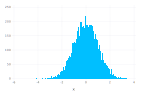

In [2]:
using Gadfly

# Note that Gadfly is JIT compiled, which means that it can take a little time
# for the first plot to render. Subsequent plots are speedy.
plot(x = randn(10000),
     Geom.histogram)

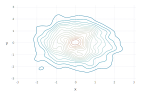

In [3]:
plot(x = randn(1000),
     y = randn(1000),
     Geom.density2d)

## Accessing and using data from Amazon S3

Here you will use the third-party AWS SDK and high-level Amazon S3 interface. The data you will use [are listed at the Registry of Open Data on AWS (RODA)](https://registry.opendata.aws/lei/), and are stored in a public S3 bucket `s3://gleif/` in Europe Frankfort (eu-central-1) region. This dataset uniquely identifies legal entities using a code and provides information about ownership structures.

You will access these data anonymously, which can be done by creating and using an `aws_config` structure with `creds=nothing`. Note that we must also supply the bucket's region with our configuration.

Our first operation will list all the keys in this S3 bucket, beginning with `data/json/lei`. You can see that the data are organized by date and time and have a `.json.gz` extension. This denotes that the files are JSON formatted and compressed with [GZip](http://www.gzip.org/).

In [4]:
using AWS
using AWSS3 # high-level interface to S3

# This AWSConfig instance allows us to make anonymous / unsigned requests
aws = global_aws_config(;creds = nothing, region = "eu-central-1")

# s3_list_keys returns a generator that we can collect immediately using collect
obj = collect(s3_list_keys(aws, "gleif", "data/json/lei/"; delimiter = ""))

4231-element Vector{String}:
 "data/json/lei/date=2018-02-09/t" ⋯ 21 bytes ⋯ "00-gleif-goldencopy-lei.json.gz"
 "data/json/lei/date=2018-02-09/t" ⋯ 21 bytes ⋯ "00-gleif-goldencopy-lei.json.gz"
 "data/json/lei/date=2018-02-09/t" ⋯ 21 bytes ⋯ "00-gleif-goldencopy-lei.json.gz"
 "data/json/lei/date=2018-02-10/t" ⋯ 21 bytes ⋯ "00-gleif-goldencopy-lei.json.gz"
 "data/json/lei/date=2018-02-10/t" ⋯ 21 bytes ⋯ "00-gleif-goldencopy-lei.json.gz"
 "data/json/lei/date=2018-02-10/t" ⋯ 21 bytes ⋯ "00-gleif-goldencopy-lei.json.gz"
 "data/json/lei/date=2018-02-11/t" ⋯ 21 bytes ⋯ "00-gleif-goldencopy-lei.json.gz"
 "data/json/lei/date=2018-02-11/t" ⋯ 21 bytes ⋯ "00-gleif-goldencopy-lei.json.gz"
 "data/json/lei/date=2018-02-11/t" ⋯ 21 bytes ⋯ "00-gleif-goldencopy-lei.json.gz"
 "data/json/lei/date=2018-02-12/t" ⋯ 21 bytes ⋯ "00-gleif-goldencopy-lei.json.gz"
 "data/json/lei/date=2018-02-12/t" ⋯ 21 bytes ⋯ "00-gleif-goldencopy-lei.json.gz"
 "data/json/lei/date=2018-02-12/t" ⋯ 21 bytes ⋯ "00-gleif-goldencopy-

Next, we’ll load one of the compressed JSON objects from the Amazon S3 bucket. This process requires decompressing the files from GZip format. Additionally, a deserialization step must occur to convert the JSON structures into Julia objects.

An Amazon S3 object can be up to 5TiB in size. Processing larger objects may require an incremental strategy; however, this lab’s objects will safely fit in memory. Therefore you can download, decompress, and parse the bucket’s contents at once.

In [5]:
using JSON, TranscodingStreams, CodecZlib

rr = JSON.parse(String(transcode(GzipDecompressor, read(S3Path("s3://gleif/data/json/rr/date=2021-12-10/time=00:00/20211210-0000-gleif-goldencopy-rr.json.gz")))))

Dict{String, Any} with 1 entry:
  "relations" => Any[Dict{String, Any}("RelationshipRecord"=>Dict{String, Any}(…

The resulting dictionary object contains a "relations" key that includes many records about the relationships between legal entities. To help us understand the structure of an individual document, we can print the first record as JSON.

In [6]:
print(json(rr["relations"][1], 4)) # the 4 tells, the json library to indent using 4 spaces

{
    "RelationshipRecord": {
        "Registration": {
            "InitialRegistrationDate": {
                "$": "2012-10-01T11:09:00.000Z"
            },
            "RegistrationStatus": {
                "$": "PUBLISHED"
            },
            "NextRenewalDate": {
                "$": "2022-06-03T13:04:00.000Z"
            },
            "LastUpdateDate": {
                "$": "2021-06-09T21:32:00.000Z"
            },
            "ValidationSources": {
                "$": "ENTITY_SUPPLIED_ONLY"
            },
            "ValidationDocuments": {
                "$": "SUPPORTING_DOCUMENTS"
            },
            "ManagingLOU": {
                "$": "EVK05KS7XY1DEII3R011"
            }
        },
        "Relationship": {
            "RelationshipStatus": {
                "$": "ACTIVE"
            },
            "EndNode": {
                "NodeIDType": {
                    "$": "LEI"
                },
                "NodeID": {
                    "$": "ZZG38T0MD

To help us do some simple analysis of these relationship records, we'll construct a DataFrame containing just a handful of fields of interest. You can extract the DataFrame using named column vectors from the dictionary we generated from the JSON from S3.

In [7]:
using DataFrames, Query

relations = DataFrame(
    startnode = map(x -> x["RelationshipRecord"]["Relationship"]["StartNode"]["NodeID"]["\$"], rr["relations"]),
    endnode = map(x -> x["RelationshipRecord"]["Relationship"]["EndNode"]["NodeID"]["\$"], rr["relations"]),
    relationshiptype = map(x -> x["RelationshipRecord"]["Relationship"]["RelationshipType"]["\$"], rr["relations"])
)

,startnode,endnode,relationshiptype
,String,String,String
1,010CMKZ3VON21WF2ZD45,ZZG38T0MDR3QY1ETUA76,IS_DIRECTLY_CONSOLIDATED_BY
2,010CMKZ3VON21WF2ZD45,3C7474T6CDKPR9K6YT90,IS_ULTIMATELY_CONSOLIDATED_BY
3,010PWNH4K3BLIC3I7R03,549300COKYB5EGSU1838,IS_DIRECTLY_CONSOLIDATED_BY
4,010PWNH4K3BLIC3I7R03,549300B2Q47IR0CR5B54,IS_ULTIMATELY_CONSOLIDATED_BY
5,01J4SO3XTWZF4PP38209,5493000HPQ4D2RZ79739,IS_DIRECTLY_CONSOLIDATED_BY
6,01J4SO3XTWZF4PP38209,5493000HPQ4D2RZ79739,IS_ULTIMATELY_CONSOLIDATED_BY
7,01TRDHWDCL69YP41S025,NZKGWYDO5O20EZTLPF09,IS_DIRECTLY_CONSOLIDATED_BY
8,01TRDHWDCL69YP41S025,LORM1GNEU1DKEW527V90,IS_ULTIMATELY_CONSOLIDATED_BY
9,020BQJXAXCZNLKIN7326,549300PFEWKNHRG25N08,IS_ULTIMATELY_CONSOLIDATED_BY


Once data are loaded into a DataFrame object, it is straightforward to perform various table operations. Here we use macros from the Query package to refine our DataFrame as a pipeline. Here we limit the results to rows where the relationship type is "IS_DIRECTLY_CONSOLIDATED_BY," grouped by values in the endnode column, and get a count of records per group. Lastly, sort the table in descending order.

In [8]:
group_sizes = relations |>
    @filter(_.relationshiptype == "IS_DIRECTLY_CONSOLIDATED_BY") |>
    @groupby(_.endnode) |>
    @map({endnode=key(_), count = length(_)}) |>
    @orderby_descending(_.count) |>
    DataFrame

,endnode,count
,String,Int64
1,784F5XWPLTWKTBV3E584,405
2,7LTWFZYICNSX8D621K86,365
3,K8MS7FD7N5Z2WQ51AZ71,362
4,W38RGI023J3WT1HWRP32,308
5,213800JH9QQWHLO99821,274
6,TKPE0FGSGCIV1TZ04B42,256
7,O4QK7KMMK83ITNTHUG69,255
8,O2RNE8IBXP4R0TD8PU41,253
9,5493000GV3I1S3MMF497,246


If you wanted to join names for all these groups, you could extract that information from the LEI data similarly housed on S3. Or suppose you are just casually interested in the top item. You can also [search for an LEI record on GLEIF's website](https://search.gleif.org/#/search/simpleSearch=784F5XWPLTWKTBV3E584&fulltextFilterId=LEIREC_FULLTEXT&currentPage=1&perPage=15&expertMode=false#search-form). In this case, the largest direct consolidator is **The Goldman Sachs Group, Inc**.

Lastly, you can plot the distribution of group sizes, once again using the Gadfly plotting library. Here you see that most direct consolidators have far fewer entries—one or two—and that there is a very long tail of larger direct consolidators.


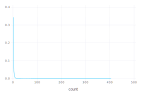

In [9]:
plot(group_sizes, x=:count, Geom.density)